# Neuro-Symbolic Integration: Learning with Logic

*Workshop created by **Satchit Chatterji** (s.chatterji@uva.nl)*  
*Part of the UvA AI MSc Course on **Explainability and Interpretability in Artificial Intelligence** (Neurosymbolic track), June 2025*
*A number of elements in this notebook have been adapted from https://github.com/tommasocarraro/LTNtorch*

> Last updated: June 17th, 2025

## Introduction

In this notebook, we explore how to teach a neural network to reason about arithmetic using both learning and logic. We will primarily use [Logic Tensor Networks (LTNs)](https://arxiv.org/pdf/2012.13635), a neurosymbolic system that integrates first-order logic with differentiable learning. LTNs (and other similar systems) allow us to express symbolic rules — like *"the sum of two numbers x and y is exactly equal to the mathematical expression x+y"*, or *"The traffic light can be red or green but not both at the same time"*, or even *“Everyone who believes in the Flying Spaghetti Monster is blessed by His Noodliness.”* — and enforce them as soft constraints during training.

---

We’ll begin with a classic simple visual task: predicting the sum of two handwritten digits (from MNIST), however, with *weak supervision*. We'll start from a purely neural perspective: given two MNIST digit images, can we **predict their sum** using a convolutional network? Additionally, can we learn **single-digit prediction** based only on their labelled sum? This is a form of *pattern recognition* — where the model must learn both the digits and their interaction.

But what happens when we **don't tell the model the individual digits**, and only provide the sum? Or better yet — what if we also **tell the model what logic governs digit addition**? This is the promise of **neurosymbolic (NeSy) methods**: blending pattern recognition with symbolic structure.

<div style="border: 3px solid #800080; padding: 1em;">
  <p>In this notebook you will:</p>
  <ol>
    <li>Train a neural model to predict sums of digit images</li>
    <li>Use <i>weak supervision</i> (sum only) instead of full labels</li>
    <li>Introduce logical rules (via <i>Logic Tensor Networks</i>)</li>
    <li>Compare different logical semantics: <b>fuzzy logic</b> vs. <b>stable real logic</b></li>
    <li>Reflect on how logic helps or hinders learning</li>
  </ol>
</div>
    
In doing so, you'll discover how logic can act as a *training signal*, guiding learning even when data is incomplete or ambiguous. This notebook will emphasize understanding over engineering. Code is provided, but you're encouraged to inspect, question, and modify it.

---

<font color='green'><b>ToDo 1</b></font> It is **highly recommended** briefly to go through the Logic Tensor Network paper before you start this notebook (specifically the part about *Real Logic*). It will greatly help with understanding the vocabulary within this notebook.


---
# 1. Task description

**Single digits addition:**
consider the predicate $addition(X, Y, n)$, where $X$ and $Y$ are
images of digits, and $n$ is a natural number corresponding to the sum of these digits. This predicate should return an
estimate of the validity of the addition. For instance, $addition(img(8), img(3), 11)$ is a
valid addition, while $addition(img(3), img(3), 5)$ is not. In this example, $img(x)$ means "an image of a $x$", where $x$ is
a digit label. It has not to be confused with a logical function.

<hr style="width:60%">
<p style="border-width:3px; border-style:solid; border-color:#800080; padding: 1em;">
<b>Analogy: Diagnosing from Medical Scans</b><br>
Imagine a model tasked with predicting a diagnosis (e.g., diabetes) from two medical scans — a retina image and a pancreas MRI. You don’t label individual findings (e.g., "lesion", "mass") — only the final diagnosis. A neural network might learn some correlation, but struggle to generalize or explain its reasoning.<br>
Now add symbolic rules like:<br>
<code>has_lesion(x) ∧ has_mass(y) → high_risk(z)</code><br>
This logic constrains the model, guiding it toward interpretable and consistent predictions — especially in ambiguous cases.<br>
<br>This notebook mirrors that challenge using MNIST digits:<br>
- The images are like the scans,<br>
- The sum is the diagnosis,<br>
- The logic (`digit1 + digit2 = sum`) is the symbolic rule.<br>
Though the experiment in this notebook may seem contrived, it captures the essence of many real-world challenges: learning from perception while reasoning with structure. We're studying how logic helps guide learning when labels are limited or incomplete.
<hr style="width:60%">
</p>

## 1.2. Dataset

Now, let's import and create the dataset.

The MNIST dataset contains 70000 images, subdivided into 60000 examples for training and 10000 for test. For our task,
we need to create an ad-hoc dataset starting from the MNIST dataset.

For the single digit case, the first 30000 images of the training set are used as left operands for the addition, while
the last 30000 images are used as right operands. The sum of the labels of the left and right operands is used as target.
The same process is repeated to create the test set. In order to test a model's ability to correctly perform single digit prediction, we also return the test image labels for the test set.

In [ ]:
#!pip install torch torchvision LTNtorch pandas numpy matplotlib seaborn scikit-learn

In [1]:
import torch
import torchvision
import pandas as pd

def get_mnist_dataset_for_digits_addition():
    """
    Prepares the dataset for MNIST single digit addition. Adapted from https://github.com/tommasocarraro/LTNtorch

    :return: a tuple of two elements. The first element is the training set, while the second element is the test set.
    Both training set and test set are lists that contain the following information:
        1. a list [left_operands, right_operands], where left_operands is a list of MNIST images that are used as the
        left operand of the addition, while right_operands is a list of MNIST images that are used as the right operand
        of the addition;
        2. a list containing the summation of the labels of the images contained in the list at point 1. The label of
        the left operand is added to the label of the right operand, and the target label is generated. This represents
        the target of the digits addition task.
    Note that this is the output of the process for the single digit case. In the multi digits case the list at point
    1 will have 4 elements since in the multi digits case four digits are involved in each addition (two digits
    represent the first operand and two digits the second operand).
    """
    n_train_examples = 30000
    n_test_examples = 5000
    n_operands = 2

    mnist_train = torchvision.datasets.MNIST("./datasets/", train=True, download=True,
                                             transform=torchvision.transforms.ToTensor())
    mnist_test = torchvision.datasets.MNIST("./datasets/", train=False, download=True,
                                            transform=torchvision.transforms.ToTensor())

    train_imgs, train_labels, test_imgs, test_labels = mnist_train.data, mnist_train.targets, \
                                                       mnist_test.data, mnist_test.targets

    train_imgs, test_imgs = train_imgs / 255.0, test_imgs / 255.0

    train_imgs, test_imgs = torch.unsqueeze(train_imgs, 1), torch.unsqueeze(test_imgs, 1)

    imgs_operand_train = [train_imgs[i * n_train_examples:i * n_train_examples + n_train_examples]
                          for i in range(n_operands)]
    labels_operand_train = [train_labels[i * n_train_examples:i * n_train_examples + n_train_examples]
                            for i in range(n_operands)]

    imgs_operand_test = [test_imgs[i * n_test_examples:i * n_test_examples + n_test_examples]
                         for i in range(n_operands)]
    labels_operand_test = [test_labels[i * n_test_examples:i * n_test_examples + n_test_examples]
                           for i in range(n_operands)]

    label_addition_train = labels_operand_train[0] + labels_operand_train[1]
    label_addition_test = labels_operand_test[0] + labels_operand_test[1]

    label_digit_train = torch.stack(labels_operand_train, dim=1)
    label_digit_test = torch.stack(labels_operand_test,dim=1)

    train_set = [torch.stack(imgs_operand_train, dim=1), label_addition_train, label_digit_train]
    test_set = [torch.stack(imgs_operand_test, dim=1), label_addition_test, label_digit_test]

    return train_set, test_set

# single digit dataset
train_set, test_set = get_mnist_dataset_for_digits_addition()

Just for illustration, we show the first example of the training set for the single digit case. This should help in
understanding how the dataset is created.

<font color='blue'><b>ToThink</b></font> Inspect the data you have been given. Make sure you understand what the data looks like, and what the labels mean.

Operands are displayed in the following images:


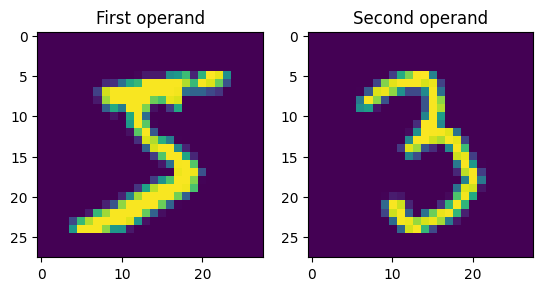

The target label (sum) for these operands is: 8


In [2]:
import matplotlib.pyplot as plt
first_example_images = train_set[0][0]
first_example_label = train_set[1][0]

print("Operands are displayed in the following images:")
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(first_example_images[0].permute(1, 2, 0))
ax.set_title('First operand')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(first_example_images[1].permute(1, 2, 0))
ax.set_title('Second operand')
plt.show()
print("The target label (sum) for these operands is: %d" % first_example_label.item())


---

## 1.3. Utils

Now, we need to define some utility classes and functions.

We define a standard PyTorch data loader, which takes as input the dataset and returns a generator of batches of data.
In particular, we need a data loader instance for training data and one for testing data.


In [3]:
import numpy as np

# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
class DataLoader(object):
    """
    Custom data loader for handling digit-pair datasets.

    Loads batches of digit image pairs and their associated sum labels.
    Designed for both supervised and semi-supervised learning setups.
    """
    def __init__(self, fold, batch_size=1, shuffle=True):
        self.fold = fold
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.fold[0].shape[0] / self.batch_size))

    def __iter__(self):
        n = self.fold[0].shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            digits = self.fold[0][idxlist[start_idx:end_idx]]
            addition_labels = self.fold[1][idxlist[start_idx:end_idx]]
            digit_labels = self.fold[2][idxlist[start_idx:end_idx]]

            yield digits, addition_labels, digit_labels

# create train and test loader
train_loader = DataLoader(train_set, 32, shuffle=True)
test_loader = DataLoader(test_set, 32, shuffle=False)

# 2. Baseline Model

As specified earlier, we design a simple convolutional neural network to predict MNIST digits. Here we split the model into two parts -- a pure ConvNet part and a set of dense layers for prediction. This is done for convenience with respect to the logic-related packages later on.


In [5]:
import torch.nn as nn

class MNISTConv(torch.nn.Module):
    """
    Convolutional neural network for single digit classification on MNIST.

    Outputs 10 logits corresponding to digit classes 0–9.
    """
    def __init__(self, conv_channels_sizes=(1, 6, 16), kernel_sizes=(5, 5), linear_layers_sizes=(256, 100)):
        super(MNISTConv, self).__init__()
        self.conv_layers = torch.nn.ModuleList([torch.nn.Conv2d(conv_channels_sizes[i - 1], conv_channels_sizes[i],
                                                                kernel_sizes[i - 1])
                                                  for i in range(1, len(conv_channels_sizes))])
        self.relu = torch.nn.ReLU()  # relu is used as activation for the conv layers
        self.tanh = torch.nn.Tanh()  # tanh is used as activation for the linear layers
        self.maxpool = torch.nn.MaxPool2d((2, 2))
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(linear_layers_sizes[i - 1], linear_layers_sizes[i])
                                                  for i in range(1, len(linear_layers_sizes))])
        self.batch_norm_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(linear_layers_sizes[i])
                                                      for i in range(1, len(linear_layers_sizes))])

    def forward(self, x):
        for conv in self.conv_layers:
            x = self.relu(conv(x))
            x = self.maxpool(x)
        x = torch.flatten(x, start_dim=1)
        for i in range(len(self.linear_layers)):
            x = self.tanh(self.batch_norm_layers[i](self.linear_layers[i](x)))
        return x


class SingleDigitClassifier(torch.nn.Module):
    """
    A wrapper for digit classification used within logic-based models.

    Typically outputs logits or fuzzy truth scores over digit values.
    """
    def __init__(self, layers_sizes=(100, 84, 10)):
        super(SingleDigitClassifier, self).__init__()
        self.mnistconv = MNISTConv()  # this is the convolutional part of the architecture
        self.tanh = torch.nn.Tanh()  # tanh is used as activation for the linear layers
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layers_sizes[i - 1], layers_sizes[i])
                                                  for i in range(1, len(layers_sizes))])
        self.batch_norm_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(layers_sizes[i])
                                                      for i in range(1, len(layers_sizes))])

    def forward(self, x):
        x = self.mnistconv(x.to(device))
        for i in range(len(self.linear_layers) - 1):
            x = self.tanh(self.batch_norm_layers[i](self.linear_layers[i](x)))
        return self.linear_layers[-1](x)  # in the last layer a sigmoid or a softmax has to be applied



## 2.2 Basic Training Loop

We now define a simple training function that trains and evaluates the baseline model.


<font color='green'><b>ToDo 2.2.1</b></font>

Complete the following function.

In [6]:
import numpy as np
import torch.nn.functional as F

def train_simple(model, optimizer, train_loader, test_loader, n_epochs=10, verbose=False):
    """
    Trains a neural model on digit addition using weak supervision from sum labels.

    This function uses soft expected value (via softmax) to infer digits and minimize MSE
    between predicted and true digit sums. Tracks multiple evaluation metrics per epoch.

    Args:
        model (nn.Module): Neural model predicting digit logits.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        train_loader (DataLoader): DataLoader yielding (images, sum, digits).
        test_loader (DataLoader): Same format for evaluation.
        n_epochs (int): Number of training epochs.
        verbose (bool): Whether to print metrics each epoch.

    Returns:
        dict: Dictionary of tracked metrics per epoch.
    """

    metrics = {
        "loss": np.full([n_epochs], np.nan),
        "test_loss": np.full([n_epochs], np.nan),
        "accuracy_sum": np.full([n_epochs], np.nan),
        "test_accuracy_sum": np.full([n_epochs], np.nan),
        "test_accuracy_digit": np.full([n_epochs], np.nan),
    }

    mse_loss = torch.nn.MSELoss()
    digit_range = torch.arange(10).float().to(device)  # for expected value

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct_sum_train = 0
        total_train = 0

        # === TRAINING ===
        for operand_images, sum_label, _ in train_loader:
            img1 = operand_images[:, 0].to(device)
            img2 = operand_images[:, 1].to(device)
            sum_label = sum_label.to(device)

            optimizer.zero_grad()
            out1 = model(img1)
            out2 = model(img2)

            probs1 = F.softmax(out1, dim=1)
            probs2 = F.softmax(out2, dim=1)

            expected1 = probs1 @ digit_range # weighted sum
            expected2 = probs2 @ digit_range
            pred_sum = expected1 + expected2

            loss = mse_loss(pred_sum.float(), sum_label.float())  # MSE loss between predicted and true sum
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Track sum accuracy
            predicted_digit1 = probs1.argmax(dim=-1)
            predicted_digit2 = probs2.argmax(dim=-1)
            predicted_sum = predicted_digit1 + predicted_digit2

            correct_sum_train += len([True for pred, label in zip(predicted_sum, sum_label) if pred == label])
            total_train += sum_label.size(0)

        metrics["loss"][epoch] = total_loss / len(train_loader)
        metrics["accuracy_sum"][epoch] = correct_sum_train / total_train

        # === EVALUATION ===
        model.eval()
        correct_sum = 0
        correct_digits = 0
        total_test = 0
        test_loss = 0

        with torch.no_grad():
            for operand_images, sum_label, digit_labels in test_loader:
                img1 = operand_images[:, 0].to(device)
                img2 = operand_images[:, 1].to(device)
                # >> img shape: (32, 1, 28, 28)
                sum_label = sum_label.to(device)
                # >> sum_label shape: (32)
                digit_labels = digit_labels.to(device)

                # your code here
                out1 = model(img1)
                out2 = model(img2)
                # >> model output shape: torch.Size([32, 10])

                probs1 = F.softmax(out1, dim=1)
                probs2 = F.softmax(out2, dim=1)
                # >> probs shape: torch.Size([32, 10])

                expected1 = probs1 @ digit_range # weighted sum
                expected2 = probs2 @ digit_range
                # >> expected shape: (32)
                # This is the expected value of the predicted digit?

                pred_sum = expected1 + expected2

                loss = mse_loss(pred_sum.float(), sum_label.float())

                test_loss += loss.item()

                predicted_digit1 = probs1.argmax(dim=-1)
                predicted_digit2 = probs2.argmax(dim=-1)
                pred_sum_class = predicted_digit1 + predicted_digit2

                # Count the number of times predicted sum is correct
                correct_sum += len([True for pred, label in zip(pred_sum_class, sum_label) if pred == label])
                # count the number of times predicted_digit1 matches the label
                correct_digits += len([True for pred, label in zip(predicted_digit1, digit_labels[:, 0]) if pred == label]) / digit_labels.shape[0]
                # count the number of times predicted_digit2 matches the label
                correct_digits += len([True for pred, label in zip(predicted_digit2, digit_labels[:, 1]) if pred == label]) / digit_labels.shape[0]
                total_test += sum_label.size(0)
                # Changed from total

        metrics["test_loss"][epoch] = test_loss / len(test_loader)
        metrics["test_accuracy_sum"][epoch] = correct_sum / total_test
        metrics["test_accuracy_digit"][epoch] = correct_digits / (2*len(test_loader))

        if verbose:
            print(f"Epoch {epoch+1} | "
                  f"Train Loss: {total_loss:.4f}, "
                  f"Train Sum Acc: {metrics['accuracy_sum'][epoch]*100:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, "
                  f"Test Sum Acc: {metrics['test_accuracy_sum'][epoch]*100:.2f}%, "
                  f"Test Digit Acc: {metrics['test_accuracy_digit'][epoch]*100:.2f}%")

    return metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SingleDigitClassifier().to(device)  # should output shape (batch, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam with lr=0.001
metrics_cnn = train_simple(model, optimizer,
                           train_loader, test_loader,
                           n_epochs=10, verbose=True)

Epoch 1 | Train Loss: 1826.4632, Train Sum Acc: 25.84%, Test Loss: 151.4389, Test Sum Acc: 30.88%, Test Digit Acc: 22.92%
Epoch 2 | Train Loss: 841.5172, Train Sum Acc: 30.65%, Test Loss: 97.1470, Test Sum Acc: 32.70%, Test Digit Acc: 32.96%
Epoch 3 | Train Loss: 627.1990, Train Sum Acc: 31.40%, Test Loss: 86.5637, Test Sum Acc: 32.94%, Test Digit Acc: 36.52%
Epoch 4 | Train Loss: 531.5772, Train Sum Acc: 31.80%, Test Loss: 87.5479, Test Sum Acc: 33.02%, Test Digit Acc: 35.80%
Epoch 5 | Train Loss: 458.0997, Train Sum Acc: 32.34%, Test Loss: 62.8808, Test Sum Acc: 33.62%, Test Digit Acc: 37.49%
Epoch 6 | Train Loss: 391.3106, Train Sum Acc: 32.72%, Test Loss: 68.9130, Test Sum Acc: 34.10%, Test Digit Acc: 46.42%
Epoch 7 | Train Loss: 368.6052, Train Sum Acc: 34.48%, Test Loss: 57.6865, Test Sum Acc: 34.82%, Test Digit Acc: 47.92%
Epoch 8 | Train Loss: 325.0940, Train Sum Acc: 34.88%, Test Loss: 57.0158, Test Sum Acc: 34.76%, Test Digit Acc: 48.61%
Epoch 9 | Train Loss: 298.4772, Train 

## 2.3. Plotting Results

We plot the results of the metrics above to make it easier to analyze learning behaviour.


<font color='green'><b>ToDo 2.3.1</b></font>

Complete the following function

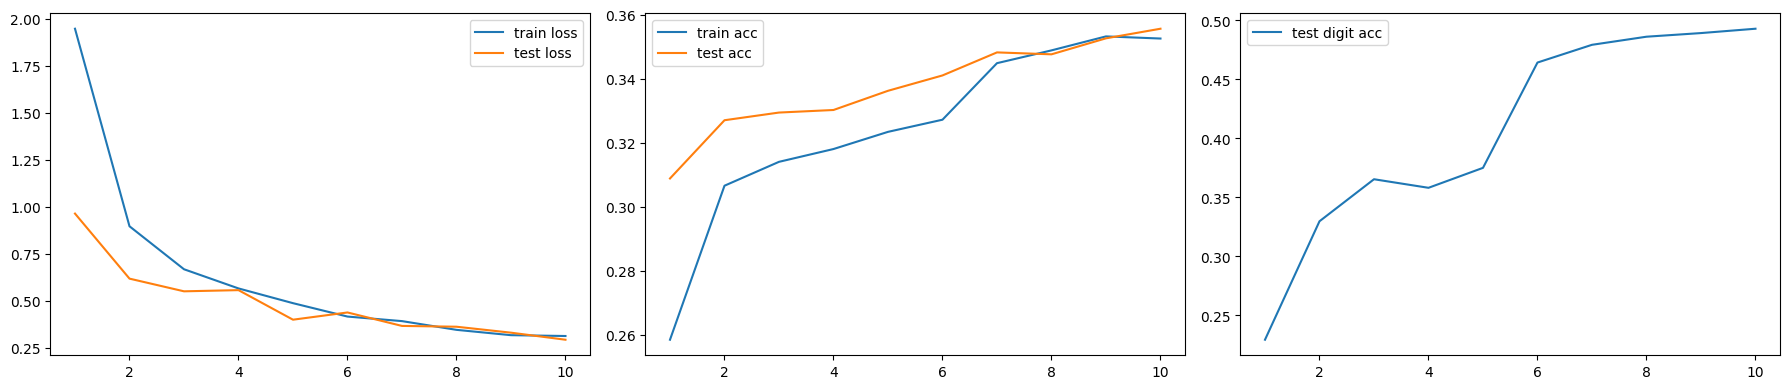

In [7]:
import matplotlib.pyplot as plt

def plot_training_metrics(metrics):
    """
    Plots 3 training metrics: loss, sum accuracy, and digit accuracy.
    """
    epochs = range(1, len(metrics["loss"]) + 1)

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    for name in ["train", "test"]:
      if name == "train":
        # --- Plot 1: Losses ---
        axs[0].plot(epochs, metrics["loss"], label="train loss")
        # --- Plot 2: Sum Accuracies ---
        axs[1].plot(epochs, metrics["accuracy_sum"], label="train acc")
      else:
        axs[0].plot(epochs, metrics["test_loss"], label="test loss")
        axs[1].plot(epochs, metrics["test_accuracy_sum"], label="test acc")
        # --- Plot 3: Digit Accuracy ---
        axs[2].plot(epochs, metrics["test_accuracy_digit"], label="test digit acc")

    for ax in axs:
      ax.legend()
    plt.tight_layout()
    plt.show()

plot_training_metrics(metrics_cnn)

---

# 3. Logic Tensor Networks: Formality

A natural neuro-symbolic approach is to seek to learn a single digit classifier and
benefit from knowledge readily available about the properties of the addition in this case.
For instance, suppose that a predicate $digit(x,d)$ gives the likelihood of an image $x$
being of digit $d$. A definition for $addition(img(3), img(8), 11)$ in LTN is:

$$\exists d_1, d_2 : d_1 + d_2 = 11 \text{ } (digit(img(3), d_1) \land digit(img(8), d_2))$$

The above task is made more complicated by not providing labels for the
single digit images during training. Instead, training takes place on pairs of images
with labels made available for the result only, that is, the sum of the individual
labels. The single digit classifier is not explicitly trained by itself. Its output is a
latent information which is used by the logic. However, this does not pose a problem
for end-to-end Neuro-symbolic systems such as LTN, for which the
gradients can propagate through the logical structures.

We start by illustrating an LTN theory that can be used to learn the predicate
$digit$. The specification of the theory below is for the single digit addition task:

<hr style="width:60%">

**Domains:**
- $images$, denoting the MNIST digit images;
- $results$, denoting the integers which are the labels for the results of the additions;
- $digits$, denoting the digits from 0 to 9.

**Variables:**
- $x, y$ ranging over the MNIST images;
- $n$ for the labels, i.e., the results of the additions;
- $d_1, d_2$ ranging over digits;
- $D(x) = D(y) = images$;
- $D(n) = results$;
- $D(d_1) = d(d_2) = digits$.

**Predicates:**
- $digit(x, d)$ for the single digit classifier, where $d$ is a term denoting a digit
constant or a digit variable. The classifier should return the probability of an
image $x$ being of digit $d$;
- $D_{in}(digit) = images,digits$.

**Axioms:**

Single digit addition:

$\forall Diag(x, y, n) \text{ } (\exists d_1, d_2 : d_1 + d_2 = n \text{ } (digit(x, d_1) \land digit(y, d_2)))$

Notice the use of $Diag$: when grounding $x,y,n$ with three sequences of values,
the *i-th* examples of each variable are matching. That is, $(\mathcal{G}(x)_i, \mathcal{G}(y)_i, \mathcal{G}(n)_i)$ is
a tuple from our dataset of valid additions. Using the diagonal quantification,
LTN aggregates pairs of images and their corresponding result, rather than any
combination of images and results.

Notice also the guarded quantification: by quantifying only on the "intermediate labels" (not given during training)
that could add up to the result label
(given during training), we incorporate symbolic information into the system.


**Grounding:**
- $\mathcal{G}(images)=[0, 1]^{28 \times 28 \times 1}$. The MNIST dataset has images of 28 by 28 pixels.
The images are grayscale and have just one channel. The RGB pixel values from
0 to 255 of the MNIST dataset are scaled to the range [0, 1];
- $\mathcal{G}(results)=\mathbb{N}$;
- $\mathcal{G}(digits) = {0, 1, \dots, 9}$;
- $\mathcal{G}(x) \in[0,1]^{m \times 28 \times 28 \times 1}, \mathcal{G}(y) \in[0,1]^{m \times 28 \times 28 \times 1}, \mathcal{G}(n) \in \mathbb{N}^{m}$.
Notice the use of the same number $m$ of examples for each of these variables as they are supposed
to match one-to-one due to the use of $Diag$;
- $\mathcal{G}\left(d_{1}\right)=\mathcal{G}\left(d_{2}\right)=\langle 0,1, \ldots, 9\rangle$;
- $\mathcal{G}(digit \mid \theta): x, d \rightarrow \operatorname{onehot}(d)^{\top} \cdot \operatorname{softmax}\left(\operatorname{CNN}_{\theta}(x)\right)$, where $CNN$
is a Convolutional Neural Network with 10 output neurons for each class. Notice that, in contrast
with the previous examples, $d$ is an integer label; $onehot(d)$ converts it into a
one-hot label.

<hr style="width:60%">

In order to define our knowledge base (axioms), we need to define predicate the $digit$, variables $d_1$ and $d_2$,
connectives, universal and existential quantifiers.

---

## 3.1 *Detour*: Differentiable Logic

Now that we've defined how terms and predicates are *grounded* in values (e.g., numbers, probabilities), we turn our attention to **logical connectives** like AND, OR, and NOT. In classical logic, these operators are binary — they yield `True` or `False`. But in neural systems, we need **differentiable** versions of these operators so that logical expressions can be optimized using gradient descent.

## 3.2 Fuzzy Operators (Connectives)

One example of a differentiable logic with well-understood semantics is **fuzzy logic**, where truth values lie in the continuous range \([0, 1]\). Logical connectives are redefined as smooth functions that ideally preserve logical structure and enable learning.

For example (Łukasiewicz):
- `fuzzy_and(a, b) = max(0, a + b - 1)`
- `fuzzy_or(a, b) = min(1, a + b)`
- `fuzzy_not(a) = 1 - a`

There are many such formulations (e.g., product logic, Gödel logic), each with different trade-offs.

<font color='blue'><b>ToThink</b></font>
> Why do you think we can't use standard Boolean logic inside a neural model? What would happen during backpropagation if our logic was non-differentiable?

<font color='green'><b>ToDo 3.2.1</b></font>
> Implement your own versions of the basic fuzzy logic operators below:
> - `fuzzy_and(a, b)`
> - `fuzzy_or(a, b)`
> - `fuzzy_not(a)`

Use PyTorch functions so they can be used in model training. The skeleton code to make it work nicely with the LTN package is given to you.

In [8]:
import ltn
from ltn.fuzzy_ops import ConnectiveOperator

class Lukasiewicz_AND(ConnectiveOperator):
    def __call__(self, x, y):
      val = x+y - 1
      # Return the element-wise maximum
      return torch.maximum(torch.zeros_like(val), val)


class Lukasiewicz_OR(ConnectiveOperator):
    def __call__(self, x, y):
      val = x+y
      # Return the element-wise minimum
      return torch.minimum(torch.ones_like(val), val)

class Lukasiewicz_NOT(ConnectiveOperator):
    def __call__(self, x):
      return 1.0 - x

# Sanity check!
# Create tensors with edge and mid-range values
a = torch.tensor([0.0, 0.3, 0.5, 0.7, 1.0])
b = torch.tensor([0.3, 0.1, 0.0, 0.7, 0.2])

and_op = Lukasiewicz_AND()
or_op = Lukasiewicz_OR()
not_op = Lukasiewicz_NOT()

print("a:", a)
print("b:", b)

print("AND (Łukasiewicz):", and_op(a, b))  # Should range [0, 1]
print("OR  (Łukasiewicz):", or_op(a, b))   # Should not exceed 1
print("NOT (Łukasiewicz):", not_op(a))     # Should reflect 1 - a

a: tensor([0.0000, 0.3000, 0.5000, 0.7000, 1.0000])
b: tensor([0.3000, 0.1000, 0.0000, 0.7000, 0.2000])
AND (Łukasiewicz): tensor([0.0000, 0.0000, 0.0000, 0.4000, 0.2000])
OR  (Łukasiewicz): tensor([0.3000, 0.4000, 0.5000, 1.0000, 1.0000])
NOT (Łukasiewicz): tensor([1.0000, 0.7000, 0.5000, 0.3000, 0.0000])


---

## 3.3 Fuzzy Operators Differentiable Quantification: Mean vs. MeanError

In LTN, universal and existential quantifiers are implemented using differentiable aggregators over truth values:

- **Forall (∀)** uses `MeanError`  
  → Emphasizes **violations** by penalizing low truth values.  
  → Makes the model work harder to satisfy *every instance*.

- **Exists (∃)** uses `Mean`  
  → Encourages **at least one** high truth value.  
  → Suitable for existential satisfaction without hard decisions.

This design balances **gradient flow** and **logical intent** — making it possible to train logic-guided models without discrete steps.

<font color='blue'><b>ToThink 2</b></font>
Though the code has been given to you for ease, please deeply understand it. Notably, the `mask` is a selector for the diagonalized selection predicate, and its application is equivalent to indexing something like `(digit1[i],digit2[i],sumlabel[i])`.

In [9]:
class AggregMean(ltn.fuzzy_ops.AggregationOperator):
    def __call__(self, xs, dim=None, keepdim=False, mask=None):
        if mask is not None:
            numerator = torch.sum(torch.where(~mask, torch.zeros_like(xs), xs))
            # we count the number of 1 in the mask
            denominator = torch.sum(mask)
            return torch.div(numerator, denominator)
        else:
            return torch.mean(xs, dim=dim, keepdim=keepdim)

class AggregMeanError(ltn.fuzzy_ops.AggregationOperator):
    def __call__(self, xs, dim=None, keepdim=False, mask=None):
        if mask is not None:
            # here, we put 1 where the mask is not satisfied, since 1 is the maximum value for a truth value.
            # this is a way to exclude values from the minimum computation
            xs = torch.where(~mask, 1., xs.double())
        out = torch.amin(xs, dim=dim, keepdim=keepdim)
        return out

## 3.4 Learning

Let us define $D$ the data set of all examples. The objective function is given by $\operatorname{SatAgg}_{\phi \in \mathcal{K}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{D}}(\phi)$.

In practice, the optimizer uses the following loss function:

$$\boldsymbol{L}=\left(1-\underset{\phi \in \mathcal{K}}{\operatorname{SatAgg}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{B}}(\phi)\right)$$


where $B$ is a mini batch sampled from $D$. As a reminder, (roughly speaking) $\mathcal{G}_{\boldsymbol{\theta}}$ is the grounded version of the following axiom:

$$\forall Diag(x, y, n) \text{ } (\exists d_1, d_2 : d_1 + d_2 = n \text{ } (digit(x, d_1) \land digit(y, d_2)))$$

This can be implemented as the following:

        sat_agg = Forall(
            ltn.diag(images_x, images_y, labels_z),
            Exists(
                vars=[d_1, d_2],
                formula=And(model(images_x, d_1), model(images_y, d_2)),
                cond_vars=[d_1, d_2, labels_z],
                cond_fn=lambda d1, d2, z: torch.eq(d1.value + d2.value, z.value),
            )
        ).value

Notice that variables $x$, $y$, and $n$ are grounded batch by batch with new data arriving from the data loader. This is exactly what
we mean with $\mathcal{G}_{x \leftarrow \boldsymbol{B}}(\phi(x))$, where $B$ is a mini-batch sampled by the data loader. Additionally, the $Diag(x,y,z)$ predicate is implemented as a conditional quantification that covers only those pairs of examples where $x+y=z$.

<font color='blue'><b>ToThink </b></font> What happens if logical constraints contradict the labeled data? How should the model resolve this tension during training?


## 3.5 Digit Predicate

For predicate $digit$, we have two models. The first one implements a $CNN$ which outputs the logits for the ten classes of
the MNIST dataset, given an image $x$ in input (this was done above within the class `SingleDigitClassifier`). The second model takes as input a labelled example $(x,d)$, it computes the logits using the first model and then returns the prediction (*softmax*) for class $d$. In other words, it computes the likelihood of image $d$ being of digit $d$. This is done below in class `LogitsToPredicate`.

We need two separated models because we need both logits and probabilities. Logits are used to compute the classification
accuracy, while probabilities are interpreted as truth values to compute the satisfaction level of the knowledge base.


In [10]:
class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label d. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class d.
    """
    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, d):
        logits = self.logits_model(x)
        probs = self.softmax(logits)
        out = torch.gather(probs, 1, d)
        return out

The variables $d_1$ and $d_2$ represent the 10 digit labels of the MNIST dataset, namely they are the sequence $\langle 0,1, \ldots, 9\rangle$.

In [11]:
# # we define the variables
d_1 = ltn.Variable("d_1", torch.tensor(range(10)))
d_2 = ltn.Variable("d_2", torch.tensor(range(10)))

## 3.6 Logic-related Training Loop

In the following, we learn our LTN for the single digit case using the fuzzy quantifiers defined earlier. We train our model for 10 epochs and use the `Adam` optimizer with a batch size of 32. The model and hyperparameters remain the same as the baseline in order to main robust comparison.

The accuracy is measured by predicting the digit values using the predicate $digit$ and reporting the ratio of
examples for which the addition is correct. Within each epoch, satisfaction level and accuracy on both training and
test data are visualized.

<font color='green'><b>ToDo </b></font>
Based on the baseline training loop from earlier, finish the following function.

In [12]:
import numpy as np
import torch.nn.functional as F


def train_logic(model, optimizer, train_loader, test_loader, And, Exists, Forall, n_epochs=30, verbose=False):
    """
    Trains a model using Logic Tensor Networks (LTN) with symbolic constraints.

    The logic enforces that predicted digits should sum to the provided label using
    LTN's `Forall` and `Exists` quantifiers. Tracks sat rate, loss, and accuracy.

    Args:
        model (LTN Predicate): A predicate object returning logits.
        optimizer (torch.optim.Optimizer): Optimizer instance.
        train_loader (DataLoader): Loader yielding image pairs and sum.
        test_loader (DataLoader): Loader with ground truth for evaluation.
        n_epochs (int): Training duration.
        verbose (bool): Print epoch-level metrics.

    Returns:
        dict: Metrics dictionary including accuracy and satisfaction rates.
    """
    metrics = {
        "loss": np.full([n_epochs], np.nan),
        "test_loss": np.full([n_epochs], np.nan),
        "accuracy_sum": np.full([n_epochs], np.nan),
        "test_accuracy_sum": np.full([n_epochs], np.nan),
        "test_accuracy_digit": np.full([n_epochs], np.nan),
        "sat": np.full([n_epochs], np.nan),
        "test_sat": np.full([n_epochs], np.nan),
    }

    d_1 = ltn.Variable("d_1", torch.tensor(range(10)))
    d_2 = ltn.Variable("d_2", torch.tensor(range(10)))

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        total_sat = 0
        correct_sum_train = 0
        total_train = 0

        for operand_images, sum_label, _ in train_loader:
            operand_images = operand_images.to(device)
            sum_label = sum_label.to(device)

            images_x = ltn.Variable("x", operand_images[:, 0])
            images_y = ltn.Variable("y", operand_images[:, 1])
            labels_z = ltn.Variable("z", sum_label)

            optimizer.zero_grad()

            sat_agg = Forall(
                ltn.diag(images_x, images_y, labels_z),
                Exists(
                    vars=[d_1, d_2],
                    formula=And(model(images_x, d_1), model(images_y, d_2)),
                    cond_vars=[d_1, d_2, labels_z],
                    cond_fn=lambda d1, d2, z: torch.eq(d1.value + d2.value, z.value),
                )
            ).value

            loss = 1.0 - sat_agg
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_sat += sat_agg.item()

            # Predict digits for accuracy tracking
            out1 = torch.argmax(model.model.logits_model(operand_images[:, 0]), dim=1)
            out2 = torch.argmax(model.model.logits_model(operand_images[:, 1]), dim=1)

            predictions = out1 + out2
            correct_sum_train += torch.count_nonzero(torch.eq(sum_label.to(ltn.device), predictions)) / predictions.shape[0]

            total_train += sum_label.size(0)

        metrics["loss"][epoch] = total_loss/ len(train_loader)
        metrics["sat"][epoch] = total_sat / len(train_loader)
        metrics["accuracy_sum"][epoch] = correct_sum_train / len(train_loader)

        # === EVALUATION ===
        model.eval()
        correct_sum = 0
        correct_digits = 0
        total = 0
        test_loss = 0
        test_sat = 0

        with torch.no_grad():
            for operand_images, sum_label, digit_labels in test_loader:

                operand_images = operand_images.to(device)
                sum_label = sum_label.to(device)
                digit_labels = digit_labels.to(device)

                """ Your code here:
                    Create x,y,z ltn variables
                    Compute the SatAgg for the test set
                    Compute the loss for the test set
                """

                # Create x,y,z ltn variables
                images_x = ltn.Variable("x", operand_images[:, 0])
                images_y = ltn.Variable("y", operand_images[:, 1])
                labels_z = ltn.Variable("z", sum_label)

                # Compute the SatAgg for the test set
                sat_agg = Forall(
                  ltn.diag(images_x, images_y, labels_z),
                  Exists(
                      vars=[d_1, d_2],
                      formula=And(model(images_x, d_1), model(images_y, d_2)),
                      cond_vars=[d_1, d_2, labels_z],
                      cond_fn=lambda d1, d2, z: torch.eq(d1.value + d2.value, z.value),
                    )
                ).value

                # Compute the loss for the test set
                loss = 1.0 - sat_agg
                test_loss += loss.item()
                test_sat += sat_agg.item()

                # Predict digits for accuracy tracking
                out1 = torch.argmax(model.model.logits_model(operand_images[:, 0]), dim=1)
                out2 = torch.argmax(model.model.logits_model(operand_images[:, 1]), dim=1)

                predictions = out1 + out2
                correct_sum += torch.count_nonzero(torch.eq(sum_label.to(ltn.device), predictions)) / predictions.shape[0]

                correct_digits += torch.count_nonzero(torch.eq(digit_labels[:, 0].to(ltn.device), out1))
                correct_digits += torch.count_nonzero(torch.eq(digit_labels[:, 1].to(ltn.device), out2))
                total += sum_label.shape[0]

        metrics["test_loss"][epoch] = test_loss/ len(test_loader)
        metrics["test_sat"][epoch] = test_sat / len(test_loader)
        metrics["test_accuracy_sum"][epoch] = correct_sum / len(test_loader)
        metrics["test_accuracy_digit"][epoch] = correct_digits / (2 * total)

        if verbose:
            print(f"Epoch {epoch+1:02d} | "
                  f"Train Sat: {metrics['sat'][epoch]:.3f} | "
                  f"Train Loss: {metrics['loss'][epoch]:.4f} | "
                  f"Train Sum Acc: {metrics['accuracy_sum'][epoch]*100:.2f}% | "
                  f"Test Sat: {metrics['test_sat'][epoch]:.3f} | "
                  f"Test Loss: {metrics['test_loss'][epoch]:.4f} | "
                  f"Test Sum Acc: {metrics['test_accuracy_sum'][epoch]*100:.2f}% | "
                  f"Test Digit Acc: {metrics['test_accuracy_digit'][epoch]*100:.2f}%")

    return metrics


We also track some important training metrics....

<font color='green'><b>ToDo 1</b></font>
Based on the earlier plotting functions for the baseline, finish the following function.

In [13]:
def plot_training_metrics_logical(metrics):
    """
    Plots 4 training metrics: loss, sat, sum accuracy, and digit accuracy.
    """
    epochs = range(1, len(metrics["loss"]) + 1)

    fig, axs = plt.subplots(1, 4, figsize=(18, 4))

    for name in ["train", "test"]:
      if name == "train":
        # --- Plot 1: Losses ---
        axs[0].plot(epochs, metrics["loss"], label="train loss")
        axs[0].set_title("Loss")
        # --- Plot 2: Satisfiability ---
        axs[1].plot(epochs, metrics["sat"], label="train sat")
        axs[1].set_title("Satisfiability")
        # --- Plot 3: Sum Accuracies ---
        axs[2].plot(epochs, metrics["accuracy_sum"], label="train acc")
        axs[2].set_title("Sum Accuracy")
      else:
        axs[0].plot(epochs, metrics["test_loss"], label="test loss")
        axs[1].plot(epochs, metrics["test_sat"], label="test sat")
        axs[2].plot(epochs, metrics["test_accuracy_sum"], label="test acc")
        # --- Plot 4: Digit Accuracy ---
        axs[3].plot(epochs, metrics["test_accuracy_digit"], label="test digit acc")
        axs[3].set_title("Digit Accuracy")

    for ax in axs:
      ax.legend()
    plt.tight_layout()
    plt.show()

And finally we run the training cycle, making sure our arguments are correct! This may take some time due to the additional computational cycles required for tracking metrics and to our new logic functions.

In [14]:
And = ltn.Connective(Lukasiewicz_AND())
Exists = ltn.Quantifier(AggregMean(), quantifier="e")
Forall = ltn.Quantifier(AggregMeanError(), quantifier="f")

cnn_s_d = SingleDigitClassifier().to(device)
Digit_s_d = ltn.Predicate(LogitsToPredicate(cnn_s_d)).to(device)
optimizer = torch.optim.Adam(Digit_s_d.parameters(), lr=0.001)

metrics_fuzzy = train_logic(Digit_s_d, optimizer, train_loader, test_loader, And, Exists, Forall, n_epochs=5, verbose=True)

Epoch 01 | Train Sat: 0.000 | Train Loss: 1.0000 | Train Sum Acc: 6.44% | Test Sat: 0.000 | Test Loss: 1.0000 | Test Sum Acc: 6.77% | Test Digit Acc: 8.88%
Epoch 02 | Train Sat: 0.000 | Train Loss: 1.0000 | Train Sum Acc: 6.51% | Test Sat: 0.000 | Test Loss: 1.0000 | Test Sum Acc: 6.91% | Test Digit Acc: 9.20%
Epoch 03 | Train Sat: 0.000 | Train Loss: 1.0000 | Train Sum Acc: 6.49% | Test Sat: 0.000 | Test Loss: 1.0000 | Test Sum Acc: 6.73% | Test Digit Acc: 8.98%
Epoch 04 | Train Sat: 0.000 | Train Loss: 1.0000 | Train Sum Acc: 6.46% | Test Sat: 0.000 | Test Loss: 1.0000 | Test Sum Acc: 6.85% | Test Digit Acc: 9.11%
Epoch 05 | Train Sat: 0.000 | Train Loss: 1.0000 | Train Sum Acc: 6.25% | Test Sat: 0.000 | Test Loss: 1.0000 | Test Sum Acc: 6.65% | Test Digit Acc: 9.06%


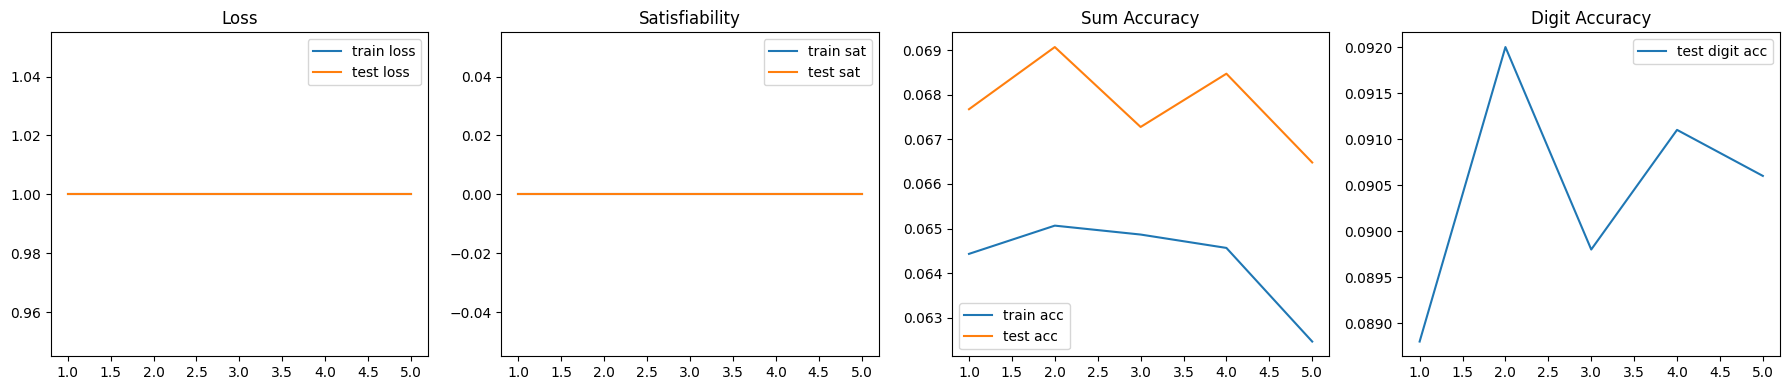

In [15]:
plot_training_metrics_logical(metrics_fuzzy)

If you're lucky, you might see your fuzzy learning model quickly converge to a subjectively good result. However, more likely than not, it may seem as if the model does not do better than random, and does not learn.

---

# 4. Why Fuzzy Logic Isn't Always Enough: The Need for Relaxations

Earlier, you implemented fuzzy logic operators like the Łukasiewicz AND and OR. These are smooth and differentiable — but that doesn't mean they're *useful* for learning.

In practice, fuzzy logics often lead to:
- **Vanishing gradients**: when the loss surface is too flat (e.g., near saturation)
- **Exploding gradients**: when logic operators sharply change over small regions
- **Violations of logical consistency** (e.g., De Morgan laws not holding)

These issues are especially problematic in complex formulas with multiple quantifiers or nested logical expressions. For a deep dive into these topics, please refer to [Van Krieken et al., 2020](https://www.sciencedirect.com/science/article/pii/S0004370221001533).

---

## 4.1 Stable Product Real Logic

The Logic Tensor Networks (LTN) paper proposes a solution:  
**Stable Real Logic**, a relaxation that preserves key logical properties (like consistency and idempotence), while maintaining smooth gradients. It redefines logic operators not just to be differentiable, but to be **semantically stable** — meaning their truth values align more reliably with classical logic under relaxation.

---

<font color='green'><b>ToDo 4.1.1</b></font>

Re-implement the logic connectives below, this time using the **stable product real logic** definitions from the LTN paper (Section 3.2):

- `Stable_AND(a, b)`
- `Stable_OR(a, b)`
- `Stable_NOT(a)`

Use the same structure as before (subclass `ConnectiveOperator`) so your logic can integrate into LTN.

**Note**: We will also use a relaxed form of the aggregators Exists and Forall, and this has already been implemented for you.

---

### <font color='blue'><b>ToThink</b></font>

- Why do you think stable real logic requires carefully engineered relaxations?
- How does it differ from simply choosing a fuzzy t-norm?

---

In [16]:
eps=1e-4

def pi_0(x):
    return (1 - eps) * x + eps
def pi_1(x):
    return (1 - eps) * x

class Stable_AND(ConnectiveOperator):
    def __call__(self, x, y):
        x, y = pi_0(x), pi_0(y)
        return x*y

class Stable_OR(ConnectiveOperator):
    def __call__(self, x, y):
      x, y = pi_1(x), pi_1(y)
      return x + y - x*y

class Stable_NOT(ConnectiveOperator):
    def __call__(self, x):
        return 1.0 - x

# Sanity check! Compare these also with the fuzzy logic results
# Create tensors with edge and mid-range values
a = torch.tensor([0.0, 0.3, 0.5, 0.7, 1.0])
b = torch.tensor([0.3, 0.1, 0.0, 0.7, 0.2])

and_op = Stable_AND()
or_op = Stable_OR()
not_op = Stable_NOT()

print("a:", a)
print("b:", b)

print("AND (Stable):", and_op(a, b))  # Should range [0, 1] (approx)
print("OR  (Stable):", or_op(a, b))   # Should not exceed 1 (approx)
print("NOT (Stable):", not_op(a))     # Should reflect 1 - a

a: tensor([0.0000, 0.3000, 0.5000, 0.7000, 1.0000])
b: tensor([0.3000, 0.1000, 0.0000, 0.7000, 0.2000])
AND (Stable): tensor([3.0007e-05, 3.0034e-02, 5.0005e-05, 4.9004e-01, 2.0008e-01])
OR  (Stable): tensor([0.3000, 0.3700, 0.4999, 0.9100, 0.9999])
NOT (Stable): tensor([1.0000, 0.7000, 0.5000, 0.3000, 0.0000])


## 4.2 Train with Stable Product Real Logic

Now that we have taken into account potential training instability, though the the learning process can still find itself in sharp local minima, we can truely train with logical constraints. The expected result is quick convergence to good results (>95% accuracy in one epoch of training). If this does not work for you, try running it a few times -- *most* of the time, it should converge to a good optima.

<font color='green'><b>ToDo 4.2.1</b></font>
Run the training for the stable product real logic connector.

In [20]:
And = ltn.Connective(Stable_AND())
# we use relaxed aggregators: see paper for details
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")

cnn_s_d = SingleDigitClassifier().to(device)
Digit_s_d = ltn.Predicate(LogitsToPredicate(cnn_s_d)).to(device)
optimizer = torch.optim.Adam(Digit_s_d.parameters(), lr=0.001)
metrics_prl = train_logic(Digit_s_d, optimizer, train_loader, test_loader, And, Exists, Forall, n_epochs=10, verbose=True)

Epoch 01 | Train Sat: 0.344 | Train Loss: 0.6557 | Train Sum Acc: 92.11% | Test Sat: 0.381 | Test Loss: 0.6185 | Test Sum Acc: 95.70% | Test Digit Acc: 97.83%
Epoch 02 | Train Sat: 0.381 | Train Loss: 0.6187 | Train Sum Acc: 96.76% | Test Sat: 0.389 | Test Loss: 0.6114 | Test Sum Acc: 96.74% | Test Digit Acc: 98.36%
Epoch 03 | Train Sat: 0.386 | Train Loss: 0.6139 | Train Sum Acc: 97.31% | Test Sat: 0.392 | Test Loss: 0.6084 | Test Sum Acc: 97.29% | Test Digit Acc: 98.64%
Epoch 04 | Train Sat: 0.389 | Train Loss: 0.6114 | Train Sum Acc: 97.64% | Test Sat: 0.393 | Test Loss: 0.6068 | Test Sum Acc: 97.31% | Test Digit Acc: 98.65%
Epoch 05 | Train Sat: 0.390 | Train Loss: 0.6098 | Train Sum Acc: 97.81% | Test Sat: 0.393 | Test Loss: 0.6070 | Test Sum Acc: 97.47% | Test Digit Acc: 98.73%
Epoch 06 | Train Sat: 0.392 | Train Loss: 0.6081 | Train Sum Acc: 98.07% | Test Sat: 0.393 | Test Loss: 0.6075 | Test Sum Acc: 97.49% | Test Digit Acc: 98.74%
Epoch 07 | Train Sat: 0.393 | Train Loss: 0.60

# 5. Comparing the Baseline with SRPL Training

<font color='green'><b>ToDo 5.1</b></font>
Complete the following function.

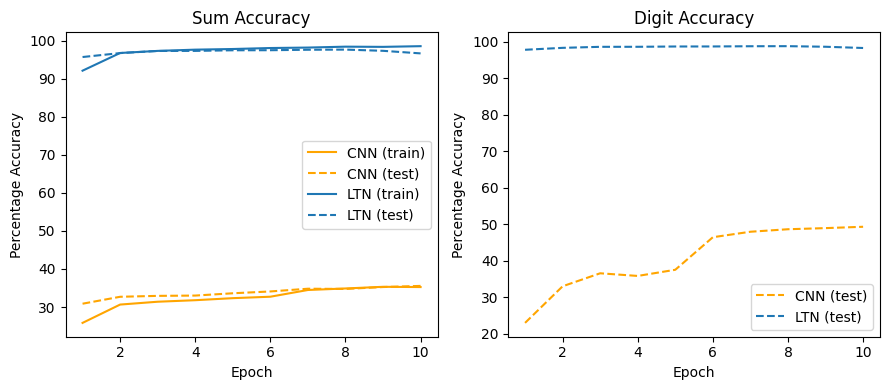

In [21]:

def compare_training_metrics(metrics_cnn, metrics_prl):
    epochs = range(1, len(metrics_cnn["accuracy_sum"]) + 1)

    orange = "#FFA500"
    blue = "#1F77B4"

    fig, axs = plt.subplots(1, 2, figsize=(9, 4))

    # --- Plot 1: Sum Accuracies ---
    # Ideally plot the test and train sum accuracies for the baseline and LTN models
    axs[0].set_title("Sum Accuracy")
    # Plot CNN baseline train and test accuracies
    axs[0].plot(epochs, metrics_cnn["accuracy_sum"]*100, c=orange, label="CNN (train)")
    axs[0].plot(epochs, metrics_cnn["test_accuracy_sum"]*100, c=orange, linestyle='dashed',
                label="CNN (test)")
    # Plot LTN train and test accuracies
    axs[0].plot(epochs, metrics_prl["accuracy_sum"]*100, c=blue, label="LTN (train)")
    axs[0].plot(epochs, metrics_prl["test_accuracy_sum"]*100, c=blue, linestyle='dashed',
                label="LTN (test)")

    # Set y-axis & x-axis
    axs[0].set_ylabel("Percentage Accuracy")
    axs[0].set_xlabel("Epoch")

    # --- Plot 2: Digit Accuracy ---
    # Ideally plot the test digit accuracies for the baseline and LTN models
    axs[1].set_title("Digit Accuracy")
    # Plot CNN baseline
    axs[1].plot(epochs, metrics_cnn["test_accuracy_digit"]*100, c=orange, linestyle='dashed',
                label="CNN (test)")
    axs[1].plot(epochs, metrics_prl["test_accuracy_digit"]*100, c=blue, linestyle='dashed',
                label="LTN (test)")

    # Set y-axis & x-axis
    axs[1].set_ylabel("Percentage Accuracy")
    axs[1].set_xlabel("Epoch")

    for ax in axs:
      ax.legend()

    plt.tight_layout()
    plt.show()

compare_training_metrics(metrics_cnn, metrics_prl)

# 6. Summary and Submissions

In this assignment, you explored Logic Tensor Networks (LTNs) for learning with partial supervision using logical constraints. You applied LTNs to a digit addition task and examined how symbolic logic improves generalization from limited labeled data.

---
<font color='red'><b>ToSubmit 6.1 (max 1 page)</b></font>  
Please submit a **brief comparative report** on the behaviour of the models you experimented with:
- **Baseline (no logic)**
- **Fuzzy Logic**
- **Stable Product Real Logic (SPRL)**

Your report should:
- Include **plots of your choice**, but must minimally show **digit accuracy** and **sum accuracy** across training and testing.
- Provide a **concise comparison** of the generalization performance and convergence speed.
- Comment on any **trade-offs observed between logical explainability and numerical stability**. About how many times on averge does the SPRL LTN converge to a good equilibria quickly? What about the Fuzzy LTN? (you may consider plotting additional plots e.g. with standard deviations if you have the time.)

Additionally, answer the following question **concisely**:

1. **What is one additional domain that requires interpretability where having prior knowledge could enhance learning?**  
   Provide a **relevant axiom**, stated in a logic formalism of your choice (e.g., FOL, fuzzy logic, modal logic, etc).



---
## Further Directions: Research in Neuro-Symbolic AI

Neuro-Symbolic (NeSy) AI is a growing interdisciplinary field that combines the statistical power of neural networks with the structured reasoning of symbolic logic. The Logic Tensor Network (LTN) framework you explored in this assignment is just one of many approaches.

Below are several research directions that may be of interest for further exploration:

### Suggested Research Directions

1. **Scalability of Logic-Based Learning**  
   Investigate how logic-augmented models like LTNs can be extended to handle large-scale datasets and complex relational structures. Consider more efficient t-norms, constraint pruning, or hybrid logic-neural sampling schemes.

2. **Explainability and Debugging**  
   Explore the use of symbolic constraints for interpreting or diagnosing neural network behavior. Can logical structure improve trust in black-box systems?

3. **Learning Logic from Data**  
   Study methods that learn logical rules directly from examples, possibly through differentiable inductive logic programming or rule extraction techniques.

4. **Multimodal Neuro-Symbolic Reasoning**  
   Extend logic-based reasoning to tasks involving vision, language, or audio. For example, define symbolic rules over object interactions in visual scenes.

5. **Probabilistic and Modal Extensions**  
   Investigate how LTNs or related frameworks could support probabilistic logic, temporal logic, or epistemic logic for richer reasoning under uncertainty and context.

6. **Neuro-Symbolic Agents**  
   Build autonomous agents capable of symbolic goal planning or logical inference, grounded in perceptual input via neural components. Also create RL agents that adhere to symbolic guardrails during exploration and deployment.

7. **Benchmarking and Evaluation**  
   Design tasks and metrics to assess generalization, consistency, robustness, and interpretability of NeSy models across domains.

8. **Probing Logical Structure in Representations**  
   Develop probing methods to evaluate whether internal representations of NeSy models reflect the underlying logical structure they are trained on. For example:
   - Are embeddings logically consistent (e.g., transitivity, symmetry)?
   - Do concept clusters reflect rule hierarchies?
   - How separable are truth values of logic predicates in latent space?

### Beyond LTNs

The Logic Tensor Network is only one approach among many. Other noteworthy Neuro-Symbolic frameworks include:
- **DeepProbLog** – neural-symbolic integration with probabilistic logic programming.
- **Neural Theorem Provers** – differentiable reasoning over symbolic rules.
- **Neuro-Symbolic Transformers** – incorporating logic constraints into large pre-trained models.
- **Differentiable ILP** – combining neural methods with rule induction.
- **Symbolic Knowledge Distillation** – extracting human-readable rules from black-box models.

Each of these approaches offers different trade-offs in terms of interpretability, scalability, supervision requirements, and reasoning capabilities.

Many fundamental questions remain open:  
- What is the right interface between perception and logic?  
- How do we balance inductive flexibility with symbolic constraints?  
- What are the theoretical limits of neuro-symbolic generalization?
- Consider a scenario where the symbolic rules are incorrect or only approximate. Should the model prioritize data or logic? How can this trade-off be managed in high-stakes situtations?